In [21]:
import sys
sys.path.insert(0, '/das/work/p17/p17983/')

In [22]:
%matplotlib nbagg
import jungfrau_utils as ju
import numpy as np
import json
import os
import time
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

import h5py

from alvra_tools.load_data import *
from alvra_tools.channels import *

In [23]:
pede_file = "/sf/alvra/data/p17983/res/JF_pedestals/pedestal_20190724_1140.JF02T09V02.res.h5"
gain_file = "/sf/alvra/config/jungfrau/gainMaps/JF02T09V02/gains.h5"

with h5py.File(gain_file, "r") as file: 
    G = file["gains"][:]
    
with h5py.File(pede_file, "r") as file: 
    P = file["gains"][:]
    mask = file["pixel_mask"][:]

print("Dimensions of G: ", G.shape)
print("Dimensions of P: ", P.shape)
print("Dimensions of mask: ", mask.shape)

# Detector name for loading module map and applying geometry
detector_name = "JF02T09V02"

Dimensions of G:  (4, 4608, 1024)
Dimensions of P:  (4, 4608, 1024)
Dimensions of mask:  (4608, 1024)


In [24]:
DIR = "/sf/alvra/data/p17983/raw/scan_data/RuBpy3_monoscan_014/"

listfile = os.listdir(DIR)
number_files = len(listfile)
print ("There are",number_files,"files in the folder", DIR)

There are 220 files in the folder /sf/alvra/data/p17983/raw/scan_data/RuBpy3_monoscan_014/


In [25]:
#N_shots_to_use = 5
N_shots_to_use = None

In [26]:
def loadJF_full(DIR, jffilename, G, P, mask, N_shots_to_use, bsreadfile, channel_BS_pulse_ids):
    
    numstds = 2
    minIzero = 0.002
    image_threshold = 1
    hot_pixel = 8
    
    (DataFluo, _, IzeroFEL, _, BS_pulse_ids, _, _, _) = \
        load_PumpProbe_events(DIR+bsreadfile, channel_BS_pulse_ids,nshots=N_shots_to_use)
    
    jf_file = h5py.File(DIR + jffilename, "r")

    print(jf_file)

    images = jf_file[f"data/{detector_name}" + channel_JF_images]
    pulse_ids = jf_file[f"data/{detector_name}" + channel_JF_pulse_ids]
    
    try:
        module_maps = jf_file[f"/data/{detector_name}/module_map"]
    except:
        module_maps = None
    
    nframes = images.shape[0]
    
    total = 0
    
    for i in range(nframes):
        image = images[i, :]
        module_map = module_maps[i, :]
        image, mask = apply_module_map(image, module_map, mask)
        image = ju.apply_gain_pede(image, G=G, P=P, pixel_mask=mask, highgain=False)#[roi[0][0]:roi[0][1], roi[1][0]:roi[1][1]]
        image_thr = image.copy()
        image_thr[image < 2] = 0
        total += image_thr
        
    total_corr = ju.apply_geometry(total, detector_name)
    
    IzeroMedian = np.median(IzeroFEL)
    IzeroSTD = np.std(IzeroFEL)

#    conditionMax = IzeroFEL < IzeroMedian+numstds*IzeroSTD
#    conditionMin = IzeroFEL > IzeroMedian-numstds*IzeroSTD
#    conditionLow = IzeroFEL > minIzero
#    condition = np.logical_and.reduce((conditionLow, conditionMin, conditionMax)).T[0]

#    images_good = images[condition,...]

#    images_thr = images_good.copy()
#    images_thr[images_good < image_threshold] = 0
#    images_thr[images_good > hot_pixel] = 0

#    print('number of surviving frames')
#    print(images_thr.shape[0])

#    total = images_thr.sum(axis=0)/images_thr.shape[0]

#    total_corr = ju.apply_geometry(total, detector_name)

    XES = np.sum(total_corr,axis=0)
    
    return XES, total_corr

In [27]:
#for ii in range(406-386+1):
for ii in range(1):
    
    filename_root = "RuBpy3_monoscan_014_step00"

    jffilename = filename_root + str(54+ii) + ".JF02T09V02.h5"
    bsreadfile = filename_root + str(54+ii) + ".BSREAD.h5"

    DIR = "/sf/alvra/data/p17983/raw/scan_data/RuBpy3_monoscan_014/"
    
    xes, vhimage = loadJF_full(DIR, jffilename, G, P, mask, N_shots_to_use, bsreadfile, channel_BS_pulse_ids)
    print(ii)
    
    if ii == 0:
        VH_sum = vhimage
        XES = xes
    else:
        VH_sum += vhimage
        XES += xes

<HDF5 file "RuBpy3_monoscan_014_step0054.JF02T09V02.h5" (mode r)>
0


<IPython.core.display.Javascript object>


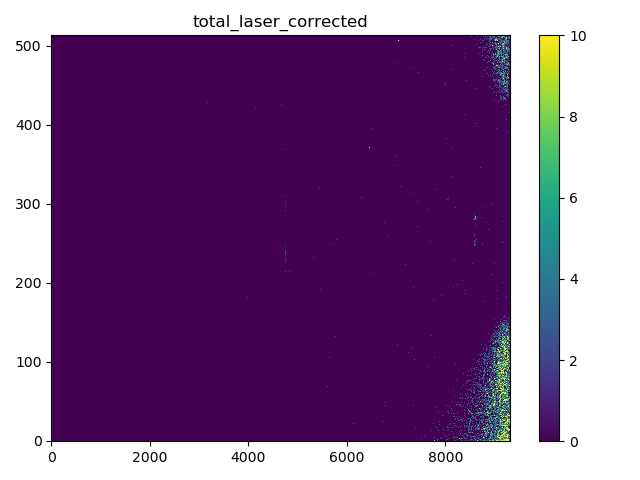

In [28]:
plt.figure()
plt.imshow(VH_sum, origin="lower", aspect='auto', vmin=0, vmax=10)
plt.colorbar()
plt.title('total_laser_corrected')
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


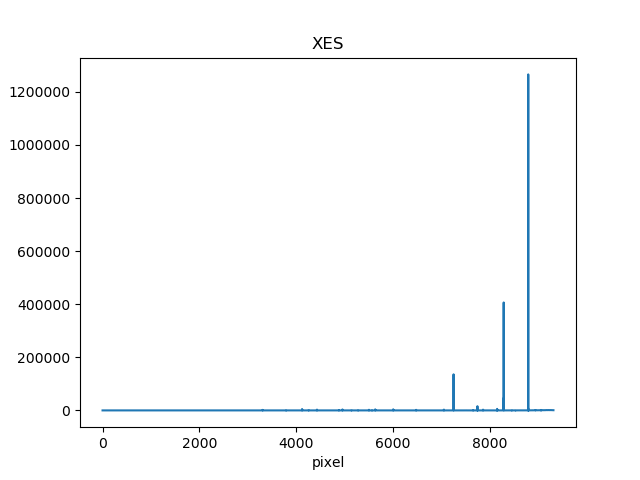

Text(0.5, 1.0, 'XES')

In [18]:
plt.figure()
plt.plot(VH_sum.sum(axis=0))
plt.xlabel('pixel')
plt.title('XES')


In [20]:
np.save('jet_JF', VH_sum)